In [33]:
!pip install tensorflow

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

In [37]:
ptb_data = pd.read_csv(r'C:\Users\jeffr\Downloads\ptb_data.csv')

In [241]:
# df_encoded = ptb_data.drop(columns = ['PTB Defence','Anonymize 1PlayerId', 'EventName', 'Club Id', 'Opposition Id', 'PTB Contest', 
#                                         'PTB Ultimate Outcome', 'WeatherConditionName'])


df_encoded = ptb_data.drop(columns = ['PTB Defence', 'Anonymize 1PlayerId', 'Player Id', 'ZonePhysical', 'MatchId', 'Tackle', 'OppScore', 'Home Score', 'Away Score', 'PTB Tackle Result', 'EventName', 'TotalPossessionSecs'])

df_encoded = pd.get_dummies(df_encoded, columns=['WeatherConditionName', 'Club Id', 'Opposition Id', 'PTB Contest', 'PTB Ultimate Outcome', 'OfficialId'], drop_first=True)


df_encoded = df_encoded.dropna()

df_encoded[df_encoded.select_dtypes(include=['bool']).columns] = df_encoded.select_dtypes(include=['bool']).astype(int)

df_encoded.info()

df_encoded.to_csv('encoded_ptb_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 111990 entries, 0 to 112026
Data columns (total 82 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   DurationSecs                                       111990 non-null  float64
 1   Half                                               111990 non-null  int64  
 2   OppPossessionSecs                                  111990 non-null  float64
 3   PositionId                                         111990 non-null  float64
 4   PossessionSecs                                     111990 non-null  float64
 5   Set Type                                           111990 non-null  int64  
 6   Total Involved Tacklers                            111990 non-null  float64
 7   Raw Tackle Number                                  111990 non-null  float64
 8   RoundId                                            111990 non-null  int64  
 9 

In [237]:
np.random.seed(0)
tf.random.set_seed(0)

In [92]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

In [242]:
nrl_train, nrl_test = train_test_split(df_encoded, test_size = 0.2,random_state=1)
df_encoded.columns = df_encoded.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

formula = 'DurationSecs ~ ' + ' + '.join(df_encoded.columns.difference(['DurationSecs']))
model = smf.ols(formula=formula, data=df_encoded).fit()
predictions = model.predict(nrl_test)
y_test = nrl_test.DurationSecs
y_train = nrl_train.DurationSecs
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           DurationSecs   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     288.2
Date:                Tue, 05 Nov 2024   Prob (F-statistic):          1.46e-125
Time:                        20:05:43   Log-Likelihood:            -1.6760e+05
No. Observations:              111990   AIC:                         3.352e+05
Df Residuals:                  111987   BIC:                         3.352e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.4071      0.011    303.729      0.000       3.385       3.429
Half                 -0.0240      0.012     -2.038      0.042      -0.047      -0.001
OppPossessionSecs     0.0002   1.23e-05     14.573      0.000       0.000       0.000
==============================================================================
Omnibus:                    13105.824   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47357.703
Skew:                           0.571   Prob(JB):                         0.00
Kurtosis:                       5.974   Cond. No.                     4.57e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [267]:
MSE_lm = np.mean((predictions-y_test)**2)
print('MSE on the test data for linear regression: ',MSE_lm)

MSE on the test data for linear regression:  1.1740740381255725


In [269]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()

X_train = nrl_train.drop('DurationSecs',axis='columns')
scaler.fit(X_train) #fit scaler (estimate mean and std) on training data only!
X_train = scaler.transform(X_train)

# apply the same transformation to test data
X_test = nrl_test.drop('DurationSecs',axis='columns')
X_test = scaler.transform(X_test)

In [271]:
print(X_train[:,1].mean(),X_train[:,1].std()) #check

7.986388683257667e-17 0.9999999999999999


In [273]:
import statsmodels.api as sm

X_train_1 = sm.add_constant(X_train)
X_test_1 = sm.add_constant(X_test)
model_sc = sm.OLS(y_train, X_train_1)
lm_scaled = model_sc.fit()

lm_scaled.summary()

predictions_scaled = lm_scaled.predict(X_test_1)

MSE_lm_scaled = np.mean((predictions_scaled-y_test)**2)
print('MSE on the test data for linear regression: ',MSE_lm_scaled)

MSE on the test data for linear regression:  0.9547626863323189


In [275]:
lm_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           DurationSecs   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     254.5
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:18:24   Log-Likelihood:            -1.2498e+05
No. Observations:               89592   AIC:                         2.501e+05
Df Residuals:                   89510   BIC:                         2.509e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5155      0.003   1077.245      0.000       3.509       3.522
x1             0.0171      0.033      0.515      0.606      -0.048       0.082
x2             0.2253      0.033      6.837      0.000       0.161       0.290
x3            -0.0502      0.004    -11.285      0.000      -0.059      -0.041
x4             0.2829      0.033      8.566      0.000       0.218       0.348
x5             0.0880      0.006     15.198      0.000       0.077       0.099
x6             0.0346      0.003     10.131      0.000       0.028       0.041
x7            -0.1370      0.005    -28.244      0.000      -0.147      -0.127
x8            -0.0148      0.004     -4.149      0.000      -0.022      -0.008
x9             0.0171      0.004      4.058      0.000       0.009       0.025
x10            0.0351      0.010      3.369      0.001       0.015       0.056
x11            0.0629      0.004     14.713      0.000       0.055       0.071
x12           -0.4380      0.060     -7.350      0.000      -0.555      -0.321
x13           -0.0239      0.030     -0.798      0.425      -0.083       0.035
x14            0.0696      0.006     11.062      0.000       0.057       0.082
x15            0.0158      0.032      0.500      0.617      -0.046       0.078
x16            0.0258      0.027      0.970      0.332      -0.026       0.078
x17           -0.0191      0.003     -5.674      0.000      -0.026      -0.013
x18            0.0211      0.008      2.612      0.009       0.005       0.037
x19            0.0098      0.003      2.840      0.005       0.003       0.017
x20           -0.0037      0.003     -1.083      0.279      -0.010       0.003
x21           -0.0019      0.003     -0.555      0.579      -0.009       0.005
x22            0.0139      0.004      3.682      0.000       0.006       0.021
x23            0.0044      0.005      0.907      0.365      -0.005       0.014
x24           -0.0092      0.004     -2.433      0.015      -0.017      -0.002
x25           -0.0309      0.005     -6.074      0.000      -0.041      -0.021
x26            0.0212      0.005      4.064      0.000       0.011       0.031
x27            0.0157      0.005      3.305      0.001       0.006       0.025
x28           -0.0015      0.005     -0.307      0.759      -0.011       0.008
x29           -0.0067      0.005     -1.369      0.171      -0.016       0.003
x30           -0.0086      0.005     -1.748      0.080      -0.018       0.001
x31            0.0308      0.005      5.927      0.000       0.021       0.041
x32            0.0230      0.005      4.658      0.000       0.013       0.033
x33           -0.0214      0.005     -4.361      0.000      -0.031      -0.012
x34            0.0215      0.005      4.378      0.000       0.012       0.031
x35           -0.0062      0.005     -1.221      0.222      -0.016       0.004
x3

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

In [277]:
type(X_train)

numpy.ndarray

In [259]:
num_features=X_train.shape[1]
print(num_features)

81


In [279]:
model = Sequential()


model.add(Input(shape=(num_features,))) # the input layer where the shape of inputs is specified, for now it is just the number of features (more advanced inputs like image data would have more dimension)
model.add(Dense(20, activation='relu')) 
model.add(Dense(20, kernel_regularizer=regularizers.l2(0.001), activation='relu')) 
model.add(Dense(1, activation='linear')) # the output layer has 1 unit, the linear activation is used as this is for regression

In [281]:
model.compile(loss='MSE', optimizer='adam')

In [283]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 20)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081 (8.13 KB)

 Trainable params: 2,081 (8.13 KB)

 Non-trainable params: 0 (0.00 B)

In [285]:
modelout = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 1.5550 - val_loss: 0.9723
Epoch 2/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 9s 984us/step - loss: 0.9536 - val_loss: 0.9537
Epoch 3/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.9362 - val_loss: 0.9495
Epoch 4/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 9s 986us/step - loss: 0.9268 - val_loss: 0.9448
Epoch 5/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9210 - val_loss: 0.9426
Epoch 6/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 9s 982us/step - loss: 0.9169 - val_loss: 0.9403
Epoch 7/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 9s 965us/step - loss: 0.9137 - val_loss: 0.9379
Epoch 8/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 9s 996us/step - loss: 0.9110 - val_loss: 0.9368
Epoch 9/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 8s 927us/step - loss: 0.9086 - val_loss: 0.9362
Epoch 10/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.9064 - val_loss: 0.9356
Epoch 11/100
8960/8960 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9045 - val_loss: 0.9346
Epoc

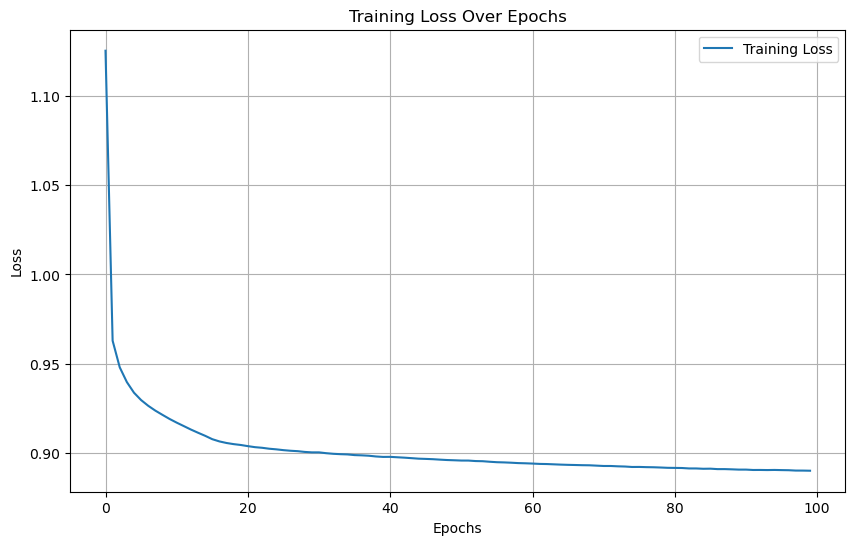

In [288]:
plt.figure(figsize=(10, 6))
plt.plot(modelout.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [290]:
MSE_nn = model.evaluate(X_test, y_test, verbose=0)
print('\nMSE on the test data for neural net: ', MSE_nn)
print('MSE on the test data for linear reg: ', MSE_lm_scaled)


MSE on the test data for neural net:  0.9341298341751099
MSE on the test data for linear reg:  0.9547626863323189
